#Modelado y Validación del Modelo
En este apartado vamos a realizar dos modelos para detectar el sentimiento en los comentarios y validar ambos modelos para escoger el mejor
### Carga de datos, división Train - Test y extracción de características

In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import RandomizedSearchCV

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from scipy.stats import uniform
from sklearn.metrics import accuracy_score

from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix 
import seaborn as sns


In [4]:
#Cargamos los datos
data = pd.read_csv('./data_model.csv', sep = ',', index_col=0)

In [5]:
#Dividimos en train - test
X_train, X_test, y_train, y_test = train_test_split(
     data['Comentario_Limpio'].values.astype('U'),
     data['Sentiment'],
     train_size=0.7,
     test_size=0.3,
     random_state=42,
     stratify=data['Sentiment'] #Estratificamos por el sentiment
)

In [6]:
#Decidimos los parametros
cv = TfidfVectorizer(
    max_df=0.95,
    min_df=5,
    max_features=5000,
    ngram_range=(1, 3)
)

In [7]:
#Entrenamos y tranformamos
cv.fit(X_train)
X_train = cv.transform(X_train)
X_test = cv.transform(X_test)

In [25]:
#Guardamos los datos de test
np.save('X_test.npy', X_test)
np.save('y_test.npy', y_test)

In [8]:
#Dividimos en train - val
X_train, X_val, y_train, y_val = train_test_split(
     X_train,
     y_train,
     train_size=0.8,
     test_size=0.2,
     random_state=42,
     stratify=y_train #Estratificamos por el sentiment
)

### Primero Modelo
Vamos a realizar un SGDCClassifier y mediante RandomizedSearch detectar los mejora parametros

In [ ]:
# Fase 1: Perdida, learning rate e incial learning rate

clf = SGDClassifier()

distributions = dict(
    loss=['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
    learning_rate=['optimal', 'invscaling', 'adaptive'],
    eta0=uniform(loc=1e-7, scale=1e-2)
)

random_search_cv = RandomizedSearchCV(
    estimator=clf,
    param_distributions=distributions,
    cv=10,
    n_iter=1000
)
random_search_cv.fit(X_train, y_train)
print(f'Best params: {random_search_cv.best_params_}')
print(f'Best score: {random_search_cv.best_score_}')

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_mo

Best params: {'eta0': 0.005957430644150354, 'learning_rate': 'adaptive', 'loss': 'hinge'}
Best score: 0.8136904761904763


In [ ]:
# Fase 2: penalty and alpha

distributions = dict(
    penalty=['l1', 'l2', 'elasticnet'],
    alpha=uniform(loc=1e-6, scale=1e-4)
)

random_search_cv = RandomizedSearchCV(
    estimator=clf,
    param_distributions=distributions,
    cv=10,
    n_iter=1000
)
random_search_cv.fit(X_train, y_train)
print(f'Best params: {random_search_cv.best_params_}')
print(f'Best score: {random_search_cv.best_score_}')

Best params: {'alpha': 9.253070689309294e-05, 'penalty': 'l1'}
Best score: 0.80625


In [ ]:
sgd_classifier = SGDClassifier(loss='hinge',
                               alpha=9.253070689309294e-05,
                               penalty='l1',
                               learning_rate = 'adaptive',
                               eta0=0.005957430644150354)
sgd_classifier.fit(X_train, y_train)

SGDClassifier(alpha=9.253070689309294e-05, eta0=0.005957430644150354,
              learning_rate='adaptive', penalty='l1')

In [ ]:
score = sgd_classifier.score(X_val, y_val)
print('Tenemos un accuracy en validacion de: ', score)

Tenemos un accuracy en validacion de:  0.8005952380952381


#Segundo Modelo
Aqui vamos a realizar una aproximación desde el Deep Learning con una RNN

In [11]:
model_DL = Sequential()
model_DL.add(Bidirectional(LSTM(100)))
model_DL.add(Dropout(0.25))
model_DL.add(Dense(1, activation='sigmoid'))


In [12]:
model_DL.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]) 

In [13]:
X_train = X_train.toarray()
X_val = X_val.toarray()

X_train = X_train[:,:,None]
X_val = X_val[:,:,None]


In [15]:
#Parametros escogidos para poder entrenar el modelo
model_DL.fit(X_train, y_train,
             validation_data = (X_val, y_val),
             batch_size=8, epochs=10)

Epoch 1/10
840/840 [==============================] - 2366s 3s/step - loss: 0.6940 - accuracy: 0.4921 - val_loss: 0.6931 - val_accuracy: 0.4994
Epoch 2/10
840/840 [==============================] - 2357s 3s/step - loss: 0.6936 - accuracy: 0.4951 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/10
840/840 [==============================] - 2362s 3s/step - loss: 0.6935 - accuracy: 0.4996 - val_loss: 0.6939 - val_accuracy: 0.5000
Epoch 4/10
840/840 [==============================] - 2356s 3s/step - loss: 0.6937 - accuracy: 0.4973 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/10
840/840 [==============================] - 2354s 3s/step - loss: 0.6936 - accuracy: 0.4830 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/10
840/840 [==============================] - 2356s 3s/step - loss: 0.6935 - accuracy: 0.4991 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 7/10
840/840 [==============================] - 2369s 3s/step - loss: 0.6938 - accuracy: 0.5040 - val_loss: 0.6932 - val_accuracy:

In [16]:
model_DL.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (8, 200)                 81600     
 l)                                                              
                                                                 
 dropout (Dropout)           (8, 200)                  0         
                                                                 
 dense (Dense)               (8, 1)                    201       
                                                                 
Total params: 81,801
Trainable params: 81,801
Non-trainable params: 0
_________________________________________________________________


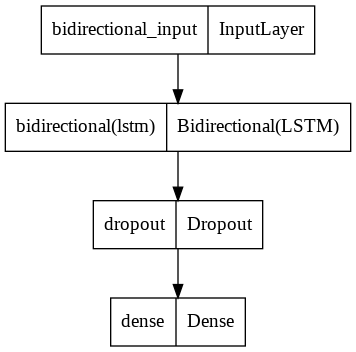

In [17]:
plot_model(model_DL)

#Validación de los Modelos
Vamos a analizar nuestros  modelos mediante el accuracy del modelo en test y la matriz de confusión

Tenemos un accuracy en test de:  0.8005952380952381


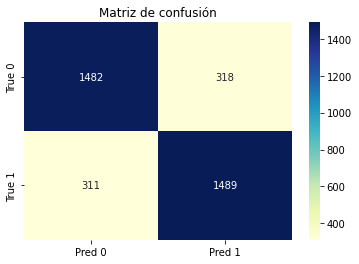

In [ ]:
#Primero evaluaremos SGD
accuracy = accuracy_score(y_test, sgd_classifier.predict(X_test))
print('Tenemos un accuracy en test de: ', score)

conf_matrix = confusion_matrix(y_test, sgd_classifier.predict(X_test))

ax = sns.heatmap(
    conf_matrix,
    cmap="YlGnBu", 
    annot=True, 
    fmt=".0f", 
    xticklabels=['Pred 0','Pred 1'],
    yticklabels=['True 0','True 1']
).set_title('Matriz de confusión')


Tenemos un accuracy en test de:  0.4997222125530243


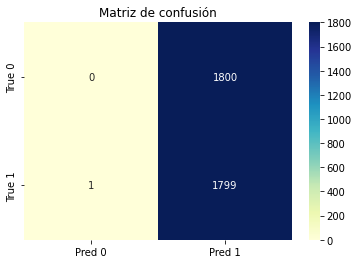

In [39]:
X_test = X_test.toarray()

X_test = X_test[:,:,None]

#Ahora evaluamos el modelo DeepLearning
score = model_DL.evaluate(X_test, y_test)
print('Tenemos un accuracy en test de: ', score[1])
y_pred = np.round(model_DL.predict(X_test), 0)

conf_matrix = confusion_matrix(y_test, y_pred)

ax = sns.heatmap(
    conf_matrix,
    cmap="YlGnBu", 
    annot=True, 
    fmt=".0f", 
    xticklabels=['Pred 0','Pred 1'],
    yticklabels=['True 0','True 1']
).set_title('Matriz de confusión')

De ambos modelos el que mejor rendimiento da es el SGD_Clasifier con un acurracy en 80% y con los errores, tanto por falso positivo como falso negativo, balanceados.

Por último comentar que el modelo de RNN da muy mal rendimiento, de un 50% de aciertos. En un modelo de predicción binario es el peor resultado posible,puesto que es como no tener modelo, bien acierta tanto como se equivoca, predice siempre 1. Es decir, el modelo no es capaz de converger reduciendo el error.

Esto puede ser producido por un error en la vectorización de la variable textual, por la necesidad de modificar la estructura de RNN o los hiperparametros de entrenamiento (alguna de estas opciones han sido escogidas por necesidad para entrenar el modelo). Por lo tanto, como vías a estudiar en proximos modelados:
- Revisar otro tipo de vectorización del texto, como utilizar una capa de embeddings.
- Modificar la red neuronal, aumentando las RNN.
- Revisar la codificación de la variable objetivo.
- Probar con otros hiperparamétros.

